# EM or Hamilton Estimation

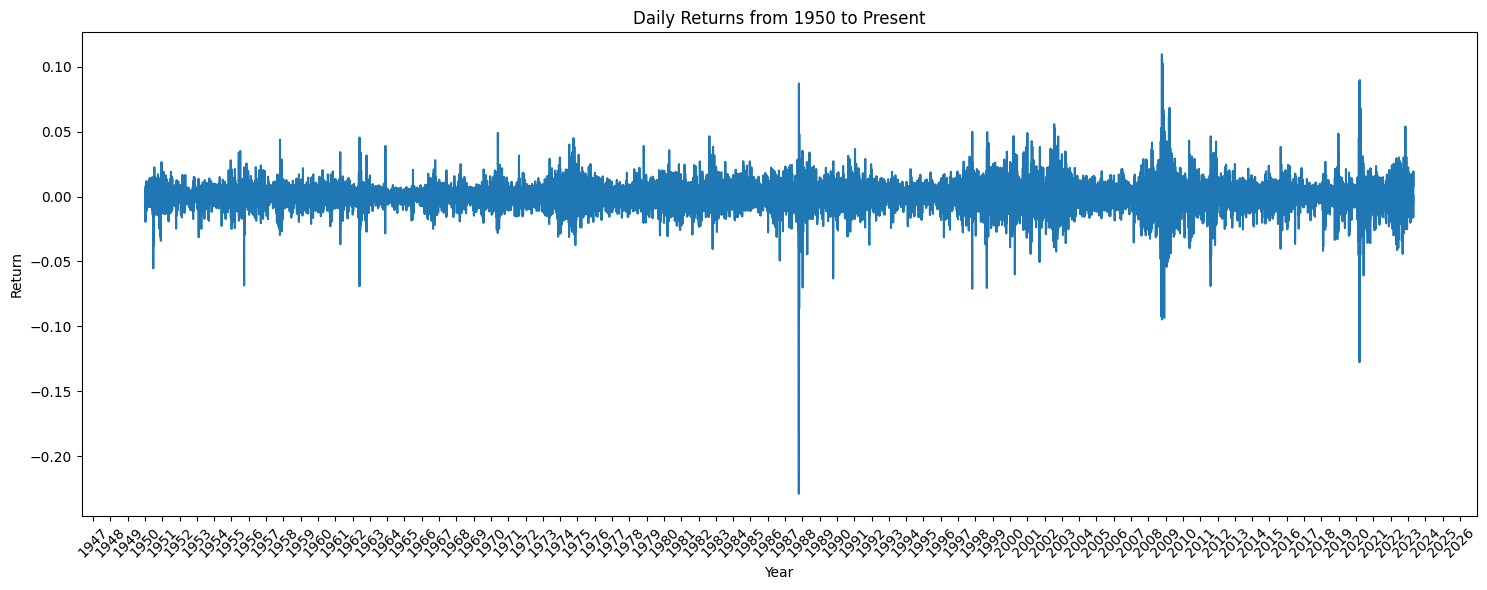

       Unnamed: 0       Date    Return
0               0 1950-01-04  0.000000
1               1 1950-01-05  0.004737
2               2 1950-01-06  0.002949
3               3 1950-01-09  0.005872
4               4 1950-01-10 -0.002932
...           ...        ...       ...
18444       18444 2023-04-24  0.000851
18445       18445 2023-04-25 -0.015937
18446       18446 2023-04-26 -0.003849
18447       18447 2023-04-27  0.019377
18448       18448 2023-04-28  0.008219

[18449 rows x 3 columns]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import EM
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from hmmlearn import hmm
from arch import arch_model
importlib.reload(EM)

df = pd.read_csv('SP500.csv', sep=';')

df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Return'])
plt.xlabel('Year')
plt.ylabel('Return')
plt.title('Daily Returns from 1950 to Present')

# Setting x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print(df)

In [24]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from arch import arch_model

# Load your data
# Assuming 'df' is your DataFrame with 'Date' and 'Return'
df = pd.read_csv('SP500.csv', sep=';') 

# Step 1: Fit a GARCH(1,1) model
#garch11 = arch_model(df['Return'], vol='Garch', p=1, q=1)
garch11 = arch_model(df['Return'], mean='ARX', vol='Garch', p=1, q=1, dist='t', power=1.0)
res = garch11.fit(update_freq=10)

# Step 2: Extract the standardized residuals and conditional volatility
std_resid = res.resid / res.conditional_volatility
vol = res.conditional_volatility

# Prepare the data for HMM
obs = np.column_stack([std_resid, vol])

# Step 3: Fit the HMM
# Number of states
n_states = 3

# Create an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")

# Fit the model
model.fit(obs)

# Predict states
hidden_states = model.predict(obs)

# Output the hidden states
print("Hidden states:")
print(hidden_states)


/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.974e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     90,   Neg. LLF: 368461.5416509688
Iteration:     20,   Func. Count:    153,   Neg. LLF: 231784.91555958305
Iteration:     30,   Func. Count:    221,   Neg. LLF: 192525.1741943675
Iteration:     40,   Func. Count:    298,   Neg. LLF: 16319.918819755487
Iteration:     50,   Func. Count:    391,   Neg. LLF: 44364.97827988223
Iteration:     60,   Func. Count:    483,   Neg. LLF: -40368.824788751816
Optimization terminated successfully    (Exit mode 0)
            Current function value: -40368.82478881785
            Iterations: 64
            Function evaluations: 483
            Gradient evaluations: 60
Hidden states:
[1 0 1 ... 0 1 0]


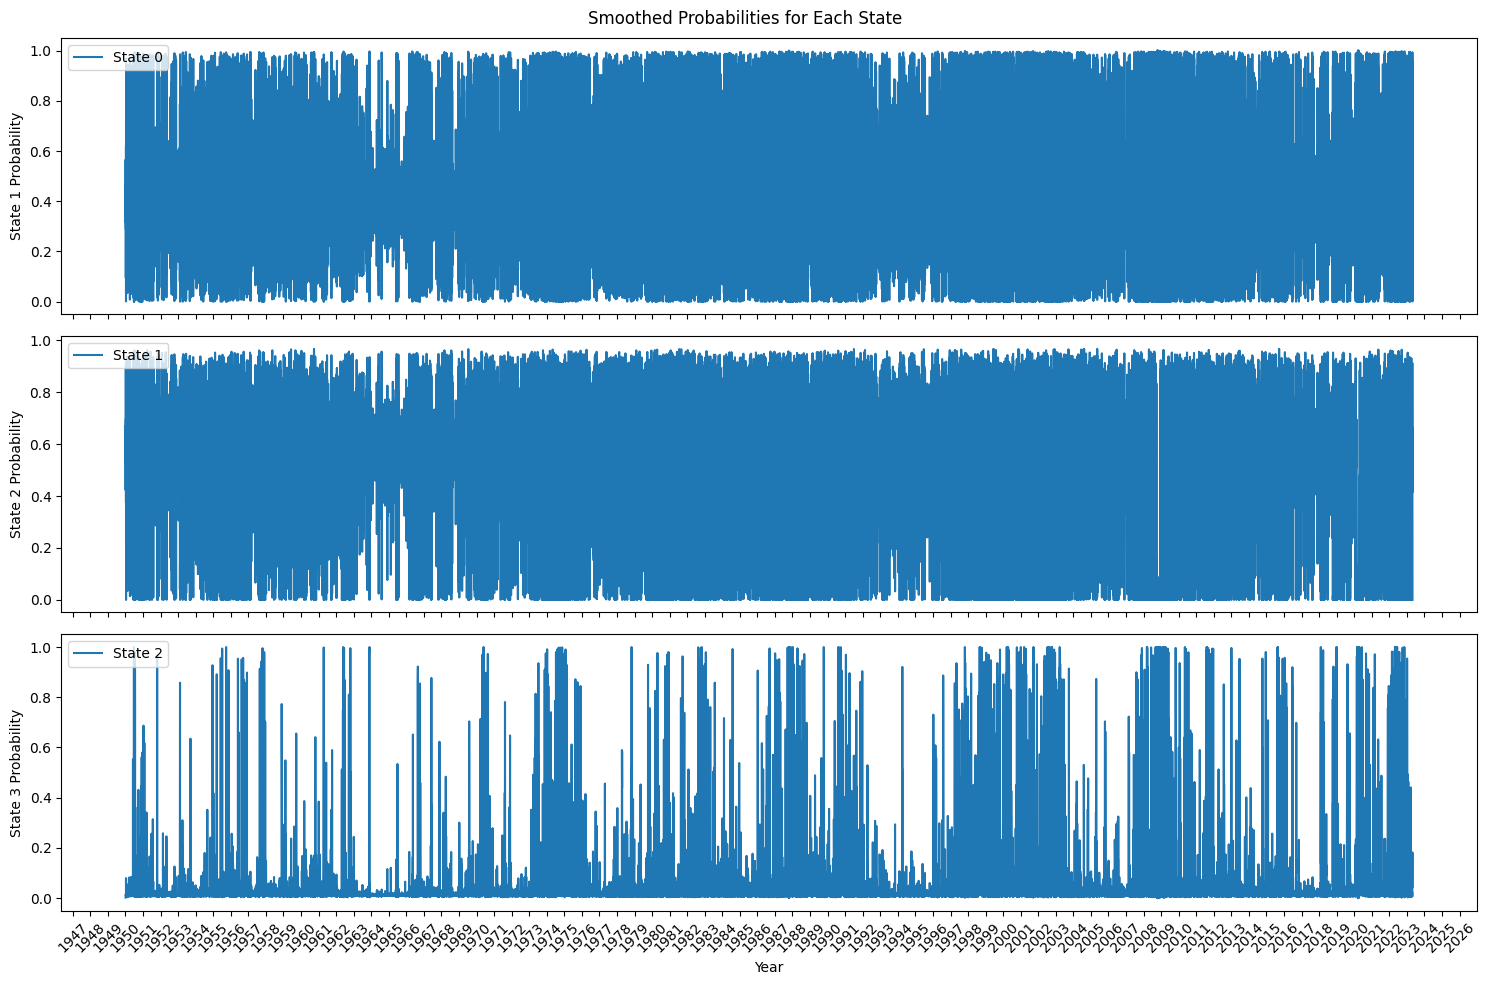

In [26]:
smoothed_probs = model.predict_proba(obs)

# Create a figure with 3 subplots (one for each state)
fig, axs = plt.subplots(model.n_components, 1, figsize=(15, 10), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(df['Date'], smoothed_probs[:, i], label=f"State {i}")
    ax.set_ylabel(f"State {i+1} Probability")
    ax.legend(loc='upper left')

    # Format x-axis to show only the years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set common labels and titles
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


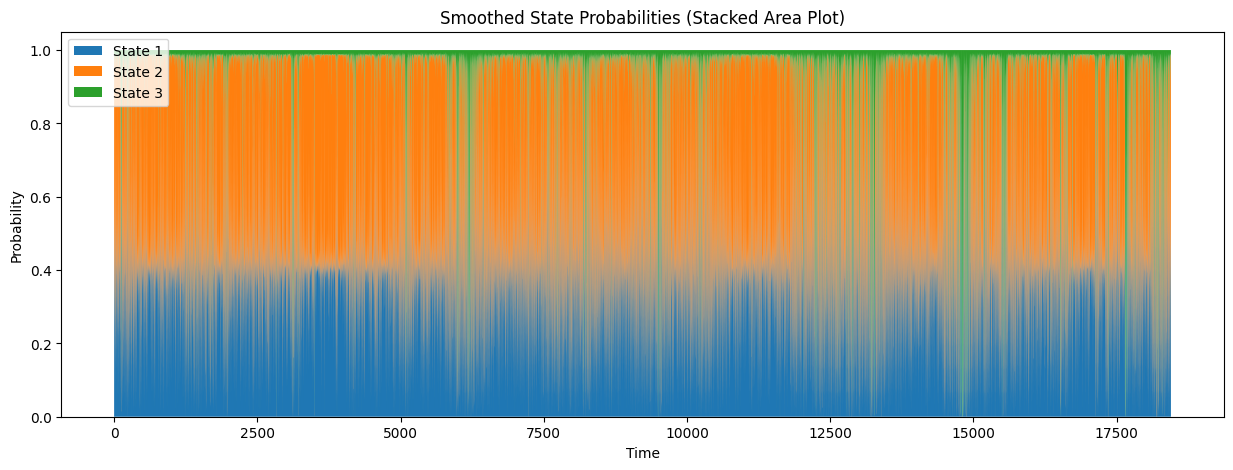

In [27]:
import matplotlib.pyplot as plt

# Assuming you already have your HMM model fitted as 'model'
# and your observations as 'obs'

# Compute smoothed probabilities


# Prepare the time axis (assuming equal intervals)
time = np.arange(len(obs))

# Plot the stacked area chart
plt.figure(figsize=(15, 5))
plt.stackplot(time, smoothed_probs.T, labels=[f"State {i+1}" for i in range(model.n_components)])

plt.title("Smoothed State Probabilities (Stacked Area Plot)")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend(loc='upper left')
plt.show()


In [28]:
# Predict the hidden states
hidden_states = model.predict(obs)

# Add the predicted states to your DataFrame
df['State'] = hidden_states

# Fit a GARCH(1,1) model for each state
garch_models = {}
for state in range(model.n_components):
    # Filter data for the current state
    state_data = df[df['State'] == state]['Return']

    # Fit a GARCH(1,1) model to this state's data
    garch11 = arch_model(state_data, mean='ARX', vol='Garch', p=1, q=1, dist='t', power=1.0)
    #garch11 = arch_model(state_data, vol='Garch', p=1, q=1)
    garch_res = garch11.fit(update_freq=10, disp='off')

    # Store the fitted model
    garch_models[state] = garch_res

# Output the summary of each model
for state, model in garch_models.items():
    print(f"State {state} GARCH(1,1) Model:")
    print(model.summary())
    print("\n")

/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.075e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.437e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/august/.venvs/jupyter/lib/python3.11/site-

State 0 GARCH(1,1) Model:
                             AR - AVGARCH Model Results                             
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                          AVGARCH   Log-Likelihood:                25945.0
Distribution:      Standardized Student's t   AIC:                          -51880.0
Method:                  Maximum Likelihood   BIC:                          -51844.8
                                              No. Observations:                 8451
Date:                      Tue, Dec 05 2023   Df Residuals:                     8450
Time:                              15:41:57   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------

/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

                             AR - AVGARCH Model Results                             
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                          AVGARCH   Log-Likelihood:                28398.6
Distribution:      Standardized Student's t   AIC:                          -56787.1
Method:                  Maximum Likelihood   BIC:                          -56751.5
                                              No. Observations:                 9176
Date:                      Tue, Dec 05 2023   Df Residuals:                     9175
Time:                              15:41:58   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------